
# **Jareer Zeenam **

## **Clustering Models using PySpark** ###

This Tutorial covers different Clustering such as  **K-Mean, Bisecting KMeans,and Gaussian Mixture Model (GMM)** using PySpark.


**Dataset**

For this exercise, we consider the most standardized open sourced dataset out there – an ** IRIS dataset.** IRIS dataset contains a total of 150 records with 5 columns (sepal length, sepal width, petal length, petal width, species). There are 50 records for each type of species. We will try to group these into clusters without using the species label information.

**Step 1: Install spark and other necessary preliminiries**

In [ ]:
# !pip install pyspark

**Step 2: Create the SparkSession Object**

SparkSession and create a new SparkSession object to use Spark:

In [59]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('K_means').getOrCreate()

**Step 3: Load and Read the Dataset**

We load and read the dataset within Spark using a dataframe.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
# upload iris dataset at google drive and provide path to the data folder
df=spark.read.csv("iris_dataset.csv",inferSchema=True,header=True)

**Step 4: Exploratory Data Analysis (EDA)**

we explore the dataset by viewing it and validating its shape.

In [61]:
print((df.count(), len(df.columns)))

(150, 5)


In [62]:
df.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

So, the above output confirms the size of our dataset and we can then validate the datatypes of the input values to check if we need to change/cast any columns' datatypes.

In [63]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



There is a total of five columns out of which four are numerical and the label column is categorical(string).

In [64]:
from pyspark.sql.functions import rand
df.orderBy(rand()).show(10,False)

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species   |
+------------+-----------+------------+-----------+----------+
|7.6         |3.0        |6.6         |2.1        |virginica |
|6.5         |3.2        |5.1         |2.0        |virginica |
|6.4         |2.9        |4.3         |1.3        |versicolor|
|5.0         |3.5        |1.3         |0.3        |setosa    |
|6.7         |2.5        |5.8         |1.8        |virginica |
|4.4         |3.0        |1.3         |0.2        |setosa    |
|5.8         |2.8        |5.1         |2.4        |virginica |
|6.7         |3.3        |5.7         |2.5        |virginica |
|5.6         |2.8        |4.9         |2.0        |virginica |
|6.2         |3.4        |5.4         |2.3        |virginica |
+------------+-----------+------------+-----------+----------+
only showing top 10 rows



In [65]:
df.select('species').distinct().count()

3

In [66]:
df.groupBy('species').count().orderBy('count').show(10,False)

+----------+-----+
|species   |count|
+----------+-----+
|virginica |50   |
|versicolor|50   |
|setosa    |50   |
+----------+-----+



So, it confirms that there are an equal number of records for each species available in the dataset

**Step 5: Feature Engineering**

This is the part where we create a single vector combining all input features by using Spark’s **VectorAssembler**. It creates only a single feature that captures the input values for that particular row. So, instead of four input columns (we are not considering a label column since it's an unsupervised machine learning technique), it essentially translates it into a single column with four input values in the form of a list.

In [67]:
from pyspark.ml.feature import VectorAssembler

In [32]:
input_cols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [71]:
vec_assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
final_data = vec_assembler.transform(df)

In [68]:
final_data.show(5)

+------------+-----------+------------+-----------+-------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|        features1|
+------------+-----------+------------+-----------+-------+-----------------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2| setosa|[4.6,3.1,1.5,0.2]|
|         5.0|        3.6|         1.4|        0.2| setosa|[5.0,3.6,1.4,0.2]|
+------------+-----------+------------+-----------+-------+-----------------+
only showing top 5 rows



### **1: Build K-Means Clustering Model**

The final data contains the input vector that can be used to run K-means clustering. Since we need to declare the value of ‘K’ in advance before using K-means, we can use **Silhouette** to figure out the right value of ‘K’.

 it measures how similar an object is to its own cluster compared to other clusters. Values range from **-1 to 1,** with higher values indicating better clustering.


In order to use the Silhouette, we run K-means clustering for different values of ‘K’. First, we import K-means from the PySpark library and create an empty list that would capture the similarity for each value of K.

In [74]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='features',
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans = KMeans(featuresCol='features', k=i)
    model = kmeans.fit(final_data)
    prediction = model.transform(final_data)
    score = evaluator.evaluate(prediction)
    silhouette_score.append(score)
    print('Silhouette Score for k =', i, 'is', score)
    

Silhouette Score for k = 2 is 0.8501515983265806
Silhouette Score for k = 3 is 0.7342113066202725
Silhouette Score for k = 4 is 0.6711848003790326
Silhouette Score for k = 5 is 0.6709352176230781
Silhouette Score for k = 6 is 0.5353298941126553
Silhouette Score for k = 7 is 0.5352427399490409
Silhouette Score for k = 8 is 0.477253611920869
Silhouette Score for k = 9 is 0.5827568911544021


A higher Silhouette Coefficient indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

Sihlouette outcome: K=2: highest Silhouette Coefficient. This suggests that 2 should be the optimal number of cluster

Ground truth: Iris dataset has 3 species, this contradicts the 2 as an optimal number of cluster. So despite k=2 having highest Silhouette Coefficient

We would consider k=3 as optimal number of clusters due to:

Iris dataset has 3 species
k=3 has a 2nd highest value of Silhouette Coefficient.
So choosing k=3 is the optimal no. of cluster for iris dataset. This is where EDA and having full context of the dataset really matters.

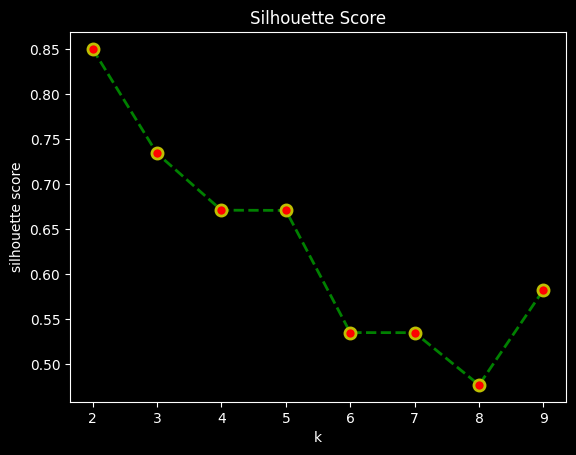

In [110]:
from IPython.display import display, HTML
plt.plot(range(2,10),
         silhouette_score, 
         marker='o', 
         linestyle='--', 
         linewidth=2,
         color='g',
         markersize=8, 
         markerfacecolor='r',
         markeredgewidth=2,
         markeredgecolor='y',
         )
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().tick_params(axis='x', colors='white')
plt.gca().tick_params(axis='y', colors='white')
plt.gca().yaxis.label.set_color('white')
plt.gca().xaxis.label.set_color('white')
plt.gca().title.set_color('white')


plt.show()

In [111]:
#Selecting k =3 for kmeans clustering
kmeans = KMeans(featuresCol='features',k=3,)

In [112]:
model = kmeans.fit(final_data)

In [117]:
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   61|
|         0|   39|
+----------+-----+



K-Means clustering gives us three different clusters based on the IRIS data set. We certainly are making a few of the allocations wrong as only one category has 50 records in the group, and the rest of the categories are mixed up. We can use the transform function to assign the cluster number to the original dataset and use a groupBy function to validate the groupings.

In [114]:
predictions=model.transform(final_data)

In [115]:
predictions.show()

+------------+-----------+------------+-----------+-------+-----------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|prediction|
+------------+-----------+------------+-----------+-------+-----------------+----------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|         1|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|         1|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|         1|
|         4.6|        3.1|         1.5|        0.2| setosa|[4.6,3.1,1.5,0.2]|         1|
|         5.0|        3.6|         1.4|        0.2| setosa|[5.0,3.6,1.4,0.2]|         1|
|         5.4|        3.9|         1.7|        0.4| setosa|[5.4,3.9,1.7,0.4]|         1|
|         4.6|        3.4|         1.4|        0.3| setosa|[4.6,3.4,1.4,0.3]|         1|
|         5.0|        3.4|         1.5|        0.2| setosa|[5.0,3.4,1.5,0.2]|         1|
|         4.4|       

In [118]:
predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   14|
| virginica|         0|   36|
|versicolor|         0|    3|
|    setosa|         1|   50|
|versicolor|         2|   47|
+----------+----------+-----+



As it can be observed, the setosa species is perfectly grouped along with versicolor, almost being captured in the same cluster, but verginica seems to fall within two different groups. K-means can produce different results every time as it chooses the starting point (centroid) randomly every time. Hence, the results that you might get in you K-means clustering might be totally different from these results unless we use a seed to reproduce the results. The seed ensures the split and the initial centroid values remain consistent throughout the analysis.

** Visualization of Clusters**

In the final step, we can visualize the new clusters with the help of Python’s matplotlib library. In order to do that, we convert our Spark dataframe into a Pandas dataframe first

In [119]:
pandas_df = predictions.toPandas()

In [120]:
pandas_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
0,5.1,3.5,1.4,0.2,setosa,"[5.1, 3.5, 1.4, 0.2]",1
1,4.9,3.0,1.4,0.2,setosa,"[4.9, 3.0, 1.4, 0.2]",1
2,4.7,3.2,1.3,0.2,setosa,"[4.7, 3.2, 1.3, 0.2]",1
3,4.6,3.1,1.5,0.2,setosa,"[4.6, 3.1, 1.5, 0.2]",1
4,5.0,3.6,1.4,0.2,setosa,"[5.0, 3.6, 1.4, 0.2]",1


We import the required libraries to plot the 3D visualization and observe the clusters.

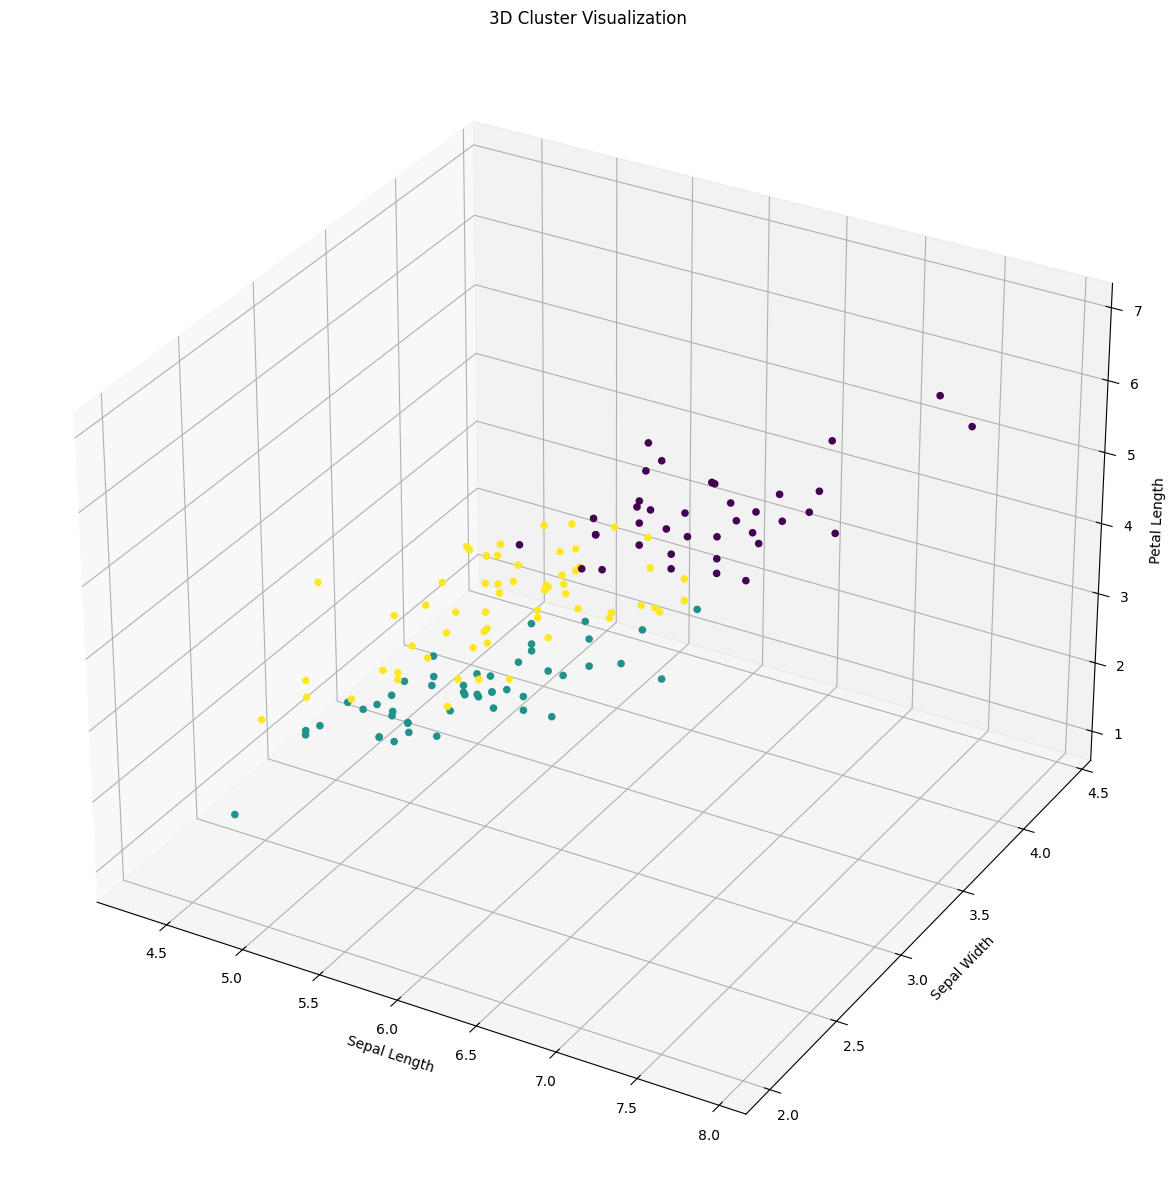

In [133]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure with 3D projection
cluster_vis = plt.figure(figsize=(15,15))
ax = cluster_vis.add_subplot(111, projection='3d')

# Scatter plot the data points with cluster labels
ax.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction, depthshade=False)

# Set labels and title
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length')
ax.set_title('3D Cluster Visualization')

# Show the plot
plt.show()


3D scatter plot with cluster labels assigned to different colors.
However, the results in the case of the iris dataset show that two out of the three species are difficult to cluster because their clusters are not **spherical** and are elongated in the possible direction clusters can form. Based on the ground truth evidence, and prior knowledge of the species, from the 3D plot, it is evidenced that k-means cluster was not able to improve clustering of the three iris species in the dataset.

### **2: Bisecting KMeans**

Bisecting k-means is a kind of hierarchical clustering using a divisive (or “top-down”) approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

Bisecting K-means can often be much faster than regular K-means, but it will generally produce a different clustering.

BisectingKMeans is implemented as an Estimator and generates a BisectingKMeansModel as the base model.

In [135]:
from pyspark.ml.clustering import BisectingKMeans

# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(3).setSeed(1)
bkm_model = bkm.fit(final_data)

# Evaluate clustering.
cost = bkm_model.computeCost(final_data)
print("Within Set Sum of Squared Errors = " + str(cost))

# Shows the result.
print("Cluster Centers: ")
centers = bkm_model.clusterCenters()
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 84.22450726272025
Cluster Centers: 
[5.00566038 3.36037736 1.56226415 0.28867925]
[5.94745763 2.76610169 4.45423729 1.45423729]
[6.85       3.07368421 5.74210526 2.07105263]


In [136]:
bisecting_kmeans_predictions = bkm_model.transform(final_data)
bisecting_kmeans_predictions.show()

+------------+-----------+------------+-----------+-------+-----------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|prediction|
+------------+-----------+------------+-----------+-------+-----------------+----------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|         0|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|         0|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|         0|
|         4.6|        3.1|         1.5|        0.2| setosa|[4.6,3.1,1.5,0.2]|         0|
|         5.0|        3.6|         1.4|        0.2| setosa|[5.0,3.6,1.4,0.2]|         0|
|         5.4|        3.9|         1.7|        0.4| setosa|[5.4,3.9,1.7,0.4]|         0|
|         4.6|        3.4|         1.4|        0.3| setosa|[4.6,3.4,1.4,0.3]|         0|
|         5.0|        3.4|         1.5|        0.2| setosa|[5.0,3.4,1.5,0.2]|         0|
|         4.4|       

In [137]:
bisecting_kmeans_predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   59|
|         2|   38|
|         0|   53|
+----------+-----+



In [138]:
bisecting_kmeans_predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   36|
|    setosa|         0|   50|
| virginica|         1|   14|
|versicolor|         1|   45|
|versicolor|         0|    3|
|versicolor|         2|    2|
+----------+----------+-----+



In [139]:
pandas_df_bkm = bisecting_kmeans_predictions.toPandas()

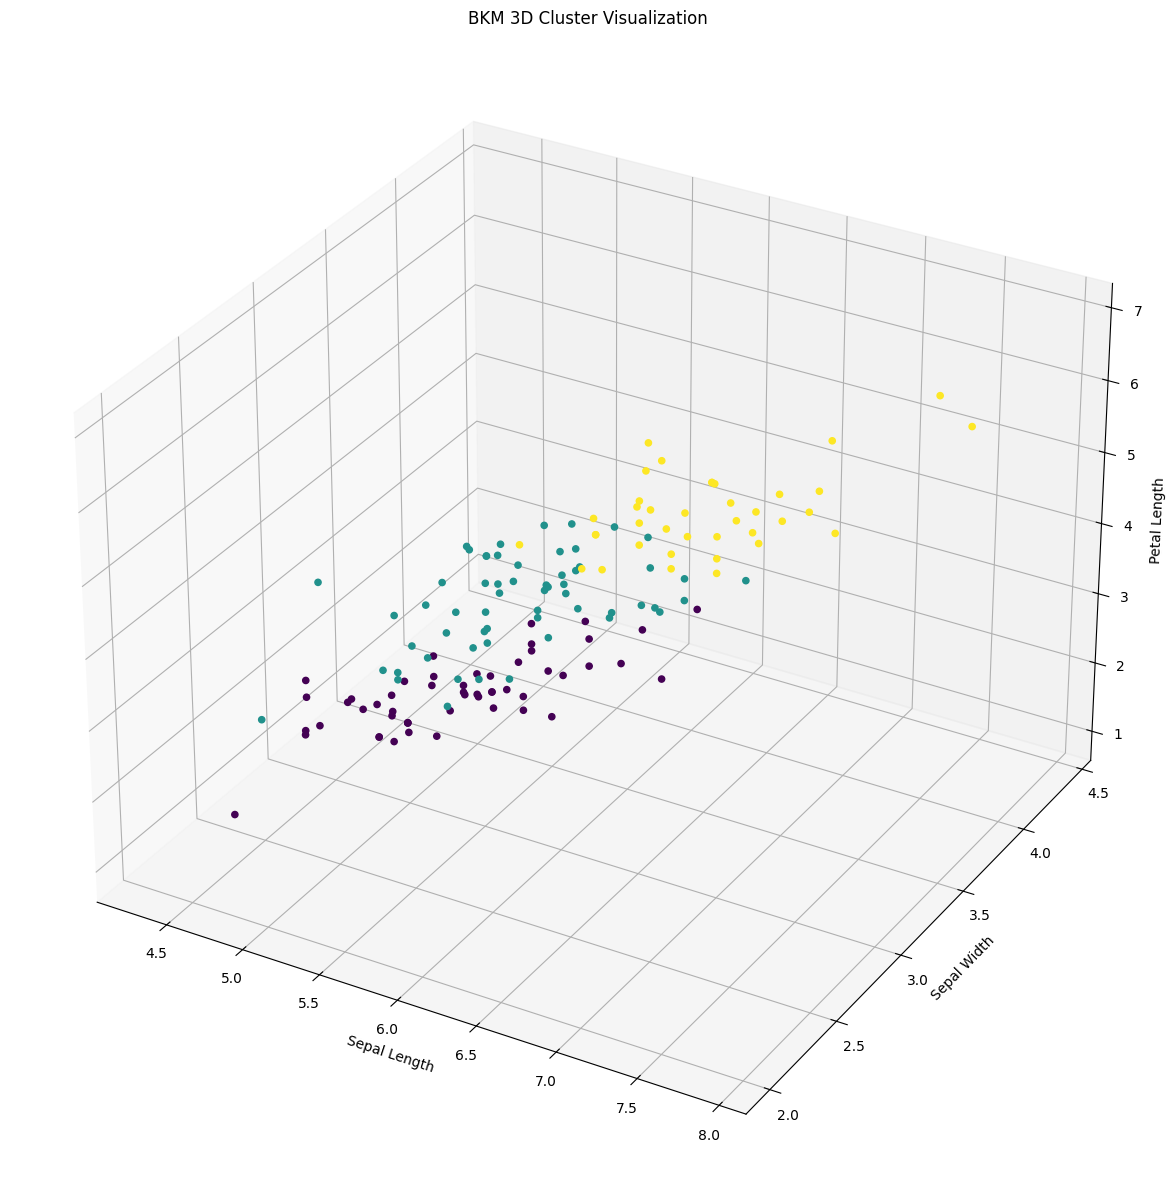

In [140]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure with 3D projection
cluster_vis = plt.figure(figsize=(15,15))
ax = cluster_vis.add_subplot(111, projection='3d')

# Scatter plot the data points with cluster labels
ax.scatter(pandas_df_bkm.sepal_length, pandas_df_bkm.sepal_width, pandas_df_bkm.petal_length, c=pandas_df_bkm.prediction, depthshade=False)

# Set labels and title
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length')
ax.set_title('BKM 3D Cluster Visualization')

# Show the plot
plt.show()

### **3: Gaussian Mixture Model (GMM)**

A Gaussian Mixture Model represents a composite distribution whereby points are drawn from one of k Gaussian sub-distributions, each with its own probability. The spark.ml implementation uses the expectation-maximization algorithm to induce the maximum-likelihood model given a set of samples.

GaussianMixture is implemented as an Estimator and generates a GaussianMixtureModel as the base model.

In [141]:
from pyspark.ml.clustering import GaussianMixture

gmm = GaussianMixture().setK(3).setSeed(538009335)
gmm_model = gmm.fit(final_data)

In [142]:
print("Gaussians shown as a DataFrame: ")
gmm_model.gaussiansDF.show(truncate=False)

Gaussians shown as a DataFrame: 
+------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|mean                                                                          |cov                                                                                                                                                                                                                                                                                                                                                                   |
+------------------------------------------------------------------------------+-------

In [143]:
gmm_predictions = gmm_model.transform(final_data)
gmm_predictions.show()

+------------+-----------+------------+-----------+-------+-----------------+--------------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|         probability|prediction|
+------------+-----------+------------+-----------+-------+-----------------+--------------------+----------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|[4.68224286509678...|         2|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|[1.00425623392062...|         2|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|[7.29177431246564...|         2|
|         4.6|        3.1|         1.5|        0.2| setosa|[4.6,3.1,1.5,0.2]|[8.74551709659989...|         2|
|         5.0|        3.6|         1.4|        0.2| setosa|[5.0,3.6,1.4,0.2]|[5.77512932671385...|         2|
|         5.4|        3.9|         1.7|        0.4| setosa|[5.4,3.9,1.7,0.4]|[2.44362895265279...|         2|
|         

In [144]:
gmm_predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   55|
|         2|   50|
|         0|   45|
+----------+-----+



In [145]:
gmm_predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
|    setosa|         2|   50|
| virginica|         1|   50|
|versicolor|         1|    5|
|versicolor|         0|   45|
+----------+----------+-----+



GMM is better at this dataset as compared to KMean and bisecting_kmeans.Compare with other two models and observe the results

In [146]:
pandas_df_gm = gmm_predictions.toPandas()

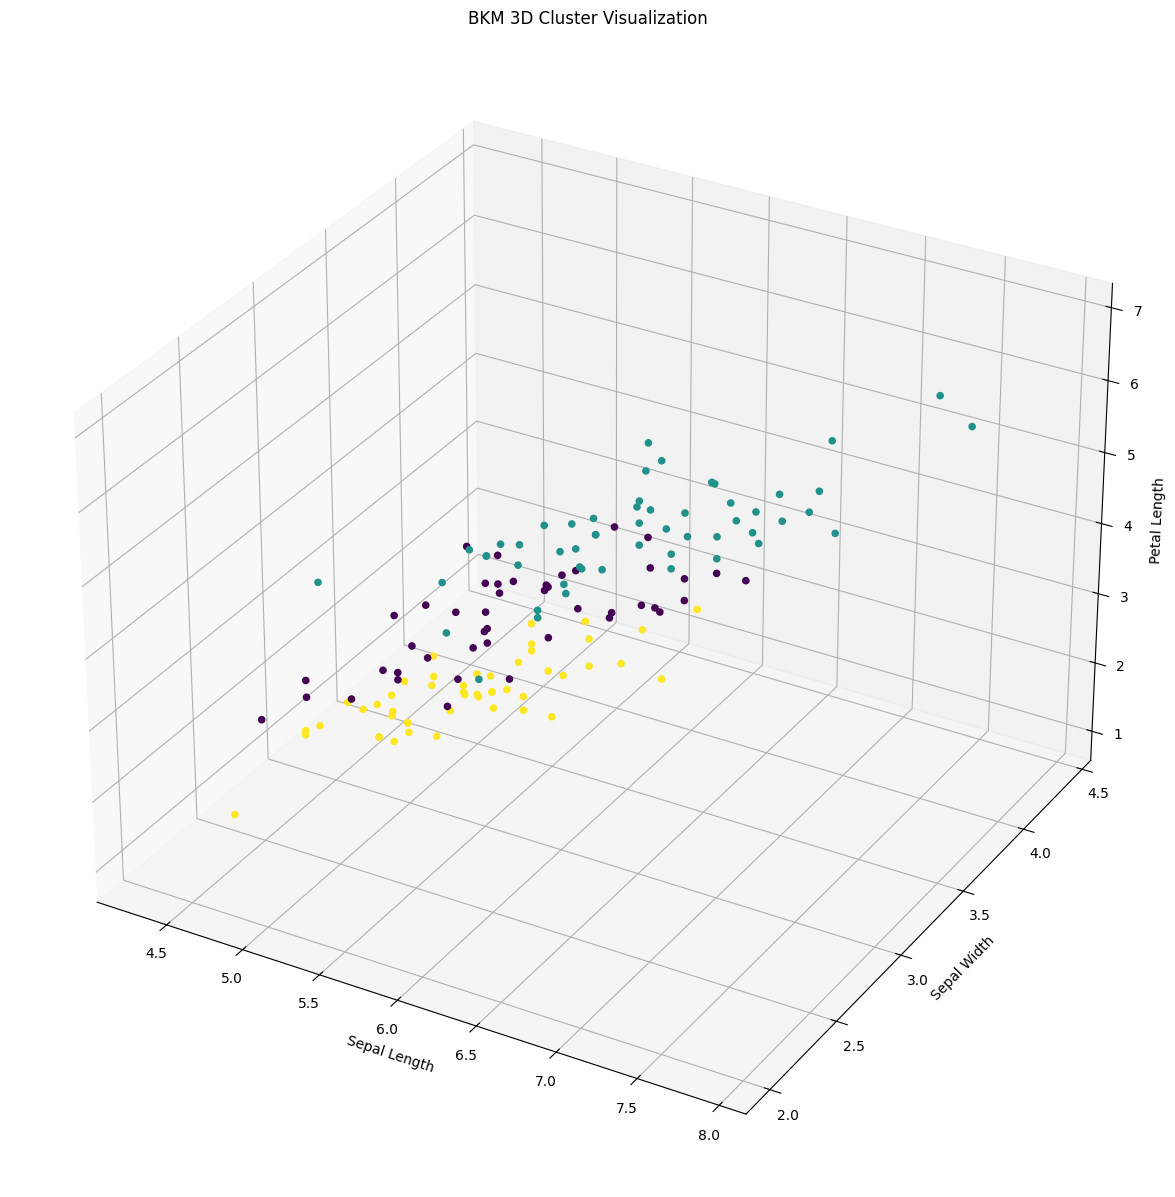

In [147]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure with 3D projection
cluster_vis = plt.figure(figsize=(15,15))
ax = cluster_vis.add_subplot(111, projection='3d')

# Scatter plot the data points with cluster labels
ax.scatter(pandas_df_gm.sepal_length, pandas_df_gm.sepal_width, pandas_df_gm.petal_length, c=pandas_df_gm.prediction, depthshade=False)

# Set labels and title
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length')
ax.set_title('BKM 3D Cluster Visualization')

# Show the plot
plt.show()

In [156]:
# Extract the mean and covariance values for each Gaussian component
import numpy as np
gaussian_df = gmm_model.gaussiansDF
mean_values = gaussian_df.select("mean").collect()
covariance_values = gaussian_df.select("cov").collect()

# Plot the Gaussian components
plt.figure(figsize=(8, 6))
for i in range(len(mean_values)):
    mean = mean_values[i][0]
    covariance = covariance_values[i][0].toArray()
    samples = np.random.multivariate_normal(mean, covariance, 100)
    x, y = samples[:, 0], samples[:, 1]
    plt.scatter(x, y, alpha=0.5, label=f"Gaussian {i+1}")

plt.title("GMM Gaussian Components")
plt.legend()
plt.show()

SyntaxError: keyword argument repeated: cmap (1069187035.py, line 14)

<Figure size 800x600 with 0 Axes>

From the guassian distributions it appears one cluster has no overlap but other two overlaps. You can extract labels and observe cluster assigned to each row in the original dataset.



In [149]:
# Extract the cluster labels
cluster_labels = gmm_predictions.select("prediction").collect()

# Convert the cluster labels to a list
cluster_labels_list = [row["prediction"] for row in cluster_labels]

# Print the cluster labels
print(cluster_labels_list)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Further Reading##
Some additional resources to learn more about clustering in Spark MLib

https://spark.apache.org/docs/latest/mllib-clustering.html#clustering-rdd-based-api



In [57]:
!jupyter nbconvert --to html "/content/drive/MyDrive/ML&Bigdata/K-Mean Clustering.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/ML&Bigdata/K-Mean Clustering.ipynb to html
[NbConvertApp] Writing 1659463 bytes to /content/drive/MyDrive/ML&Bigdata/K-Mean Clustering.html
